# Packages

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Functions

In [4]:
def split_and_expand(row):
    """Split a string data accross coma
    """
    return pd.Series(row.split(','))   

def raw_data_to_dataframe(df_unseparated):
    """From a raw DataFrame returns a clean DataFrame separated on the coma.
    """ 

    columns_name = df_unseparated.columns[0].split(',')

    values = df_unseparated['Date,Open,High,Low,Close,Adj Close,Volume'].apply(split_and_expand).values

    return pd.DataFrame(values, columns=columns_name)

def df_of_aggregated_data(df_raw):
    """From Yahoo.fr export, returns a dataframe with the asset as ticker.
    """
    df_aggregated = pd.DataFrame()

    for indice in list(df_raw.keys()):
        df_raw[indice] = raw_data_to_dataframe(df_raw[indice])
        # Add the ticker on the dataframe
        df_raw[indice]['Ticker'] = [indice]*len(df_raw[indice])
        # concat all the data frame
        df_aggregated = pd.concat([df_aggregated, df_raw[indice]], axis=0)

    return df_aggregated.set_index('Date')


def convert_index_to_datetime(df):
    """
    Convert the index of a DataFrame from a string date format (YYYY-MM-DD) to datetime format.
    
    Parameters:
    - df: pandas DataFrame
    
    Returns:
    - pandas DataFrame with the index converted to datetime format
    """
    # Check if the DataFrame has an index
    if not isinstance(df.index, pd.DatetimeIndex):
        # Convert the index to datetime format
        df.index = pd.to_datetime(df.index)
    
    return df
    
def transform_df_with_str_values_into_float(df, columns_to_change):
    df[columns_to_change] = df[columns_to_change].apply(pd.to_numeric, errors='coerce')
    return df

def crop_dataframe(df, begin_date='1000-01-01', end_date='3000-01-01', all_dates=False):
    """
    Crop a DataFrame between two specified dates, keeping all occurrences of the dates if specified.

    Parameters:
    - df: pandas DataFrame
    - begin_date: str, format 'YYYY-MM-DD'
    - end_date: str, format 'YYYY-MM-DD'
    - all_dates: bool, if True, keep all data, regardless of the date interval (default: False)

    Returns:
    - pandas DataFrame cropped between begin_date and end_date (or the original DataFrame if all_dates is True)
    """
    # If all_dates is True, return the original DataFrame
    if all_dates:
        return df
    
    else:
        # Convert input dates to datetime format
        begin_date = pd.to_datetime(begin_date)
        end_date = pd.to_datetime(end_date)

        # Boolean indexing to keep all occurrences of dates within the specified interval
        cropped_df = df[(df.index >= begin_date) & (df.index <= end_date)]

        return cropped_df


# Functions for empirical moments
def get_mu_hat(gross_returns_table, end_date_for_the_empirical_sum):
    
    mu_hat_TIME_T = gross_returns_table.loc[:pd.to_datetime(end_date_for_the_empirical_sum)].mean(axis=0)

    return mu_hat_TIME_T.values

def get_omega_hat(gross_returns_table, end_date_for_the_empirical_sum):
    mu_hat = get_mu_hat(gross_returns_table=gross_returns_table, end_date_for_the_empirical_sum=end_date_for_the_empirical_sum)
    Y_minus_mu_hat = gross_returns_table - mu_hat

    omega_hat = np.zeros((len(Y_minus_mu_hat.columns),len(Y_minus_mu_hat.columns)))
    
    for date in Y_minus_mu_hat.index:
        Y_date_minus_mu_hat = Y_minus_mu_hat.loc[date].values.reshape(len(Y_minus_mu_hat.columns), 1)
        matrix_product_for_date = np.dot(Y_date_minus_mu_hat, Y_date_minus_mu_hat.T)
        omega_hat += matrix_product_for_date

    omega_hat /= len(omega_hat)
    
    return omega_hat


In [5]:
def create_stock_dataframe(tickers, start_date, end_date):
    data = {} 

    for ticker in tickers:
        # Pour télécharger les données boursières avec une fréquence mensuelle "1mo"
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval='1mo')
        # Pour extraire et stocker les prix de clôture ajustés "Adj Close"
        data[ticker] = stock_data['Adj Close']
    df = pd.DataFrame(data)
    
    return df


# Download and clean data

In [6]:
# Créaiton du DataFrame
tickers = ['JPM', 'BP', 'AAPL','JNJ','MSFT','PG','V','HD','GE','PFE']
start_date = '2020-01-01'
end_date = '2023-12-01'
stock_df = create_stock_dataframe(tickers, start_date, end_date)
stock_df


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,JPM,BP,AAPL,JNJ,MSFT,PG,V,HD,GE,PFE
Date,,,,,,,,,,
2020-01-01,117.284706,29.154240,75.383636,133.691223,164.040085,112.892754,193.532990,207.160873,76.602264,30.266420
2020-02-01,103.546028,25.248714,66.579002,120.768433,156.118973,103.184013,176.793259,197.842682,66.942398,27.439220
2020-03-01,80.288071,20.020250,62.081356,118.510933,152.390457,100.240570,156.944244,169.570343,48.853176,26.798801
2020-04-01,85.398048,19.535959,71.727165,135.601151,173.165253,107.412338,174.088089,200.985779,41.880543,31.495157
2020-05-01,87.682091,18.994207,77.620621,134.435272,177.069000,106.339828,190.179947,227.179825,40.463989,31.355585
2020-06-01,84.753670,19.656654,89.301910,127.977745,197.193268,109.688171,188.478638,229.035797,42.065311,27.115631
2020-07-01,87.078377,18.577732,104.048492,132.646210,198.646759,120.283615,185.775955,244.181091,37.440590,31.908548
2020-08-01,91.156845,17.642101,126.354362,139.607941,218.529831,127.698517,206.841599,262.161957,39.105988,31.642654
2020-09-01,87.590271,14.910812,113.604187,136.387268,204.294266,128.307831,195.408463,255.420303,38.427486,30.729967


# Plot index evolution

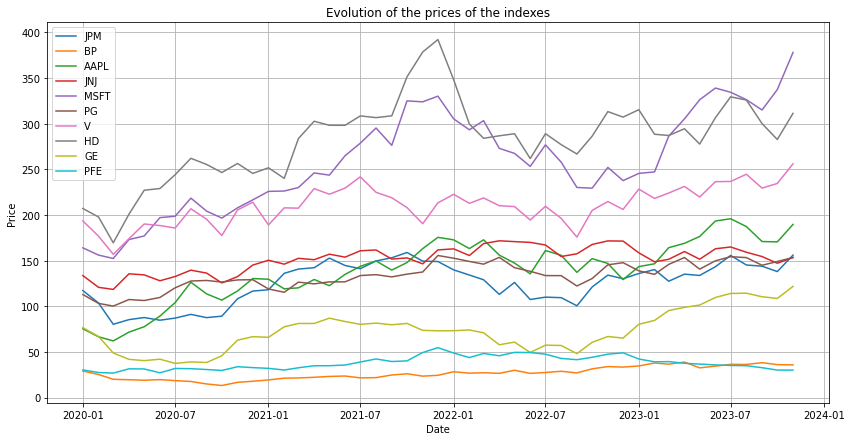

In [7]:
plt.figure(figsize=(14, 7))
for c in stock_df.columns.values:
    plt.plot(stock_df.index, stock_df[c], label=c)
plt.legend()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Evolution of the prices of the indexes')
plt.show()

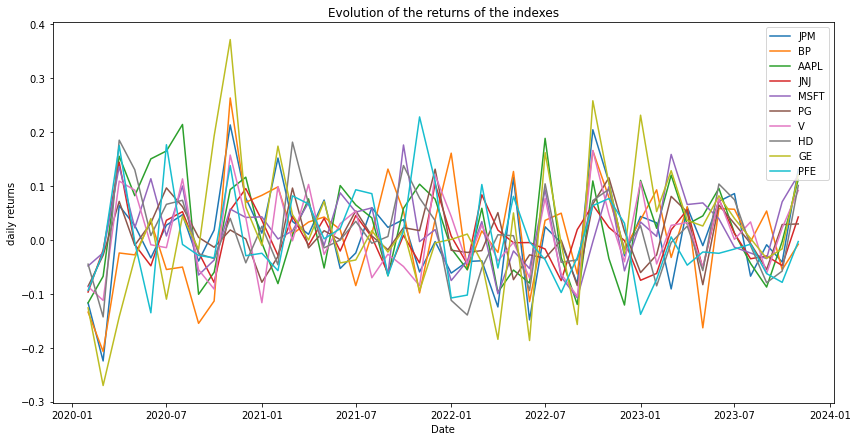

In [8]:
returns = stock_df.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], label=c)
plt.legend()
plt.ylabel('daily returns')
plt.xlabel('Date')
plt.title('Evolution of the returns of the indexes')
plt.show()

# Efficient frontier representation

## Test the stationarity of the returns

In [9]:
# For testing stationarity
P_VALUE = 0.01

In [10]:
Y = returns+1
Y_full = Y.iloc[1:]

for index in Y.columns:
    # ADF Test for Stationarity
    result = adfuller(Y_full[index].values, autolag='AIC')

    # Extract and print the results
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print('__________________________')
    print(f'Stationarity test for {index} index')
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')

    # Interpret the results
    if p_value <= P_VALUE:
        print(f'Then for a p-value of {P_VALUE}, the time series is likely stationary (reject the null hypothesis of non-stationarity).')
    else:
        print(f'Then for a p-value of {P_VALUE}, the time series is likely non-stationary (fail to reject the null hypothesis).')

__________________________
Stationarity test for JPM index
ADF Statistic: -3.2072961965805886
p-value: 0.019566212186588754
Critical Values:
   1%: -3.5925042342183704
   5%: -2.931549768951162
   10%: -2.60406594375338
Then for a p-value of 0.01, the time series is likely non-stationary (fail to reject the null hypothesis).
__________________________
Stationarity test for BP index
ADF Statistic: -6.570944686619118
p-value: 7.939143959682354e-09
Critical Values:
   1%: -3.584828853223594
   5%: -2.9282991495198907
   10%: -2.6023438271604937
Then for a p-value of 0.01, the time series is likely stationary (reject the null hypothesis of non-stationarity).
__________________________
Stationarity test for AAPL index
ADF Statistic: -5.750897780661383
p-value: 5.970022207606333e-07
Critical Values:
   1%: -3.5885733964124715
   5%: -2.929885661157025
   10%: -2.6031845661157025
Then for a p-value of 0.01, the time series is likely stationary (reject the null hypothesis of non-stationarity).

## Empirical moments

In [11]:
TIME_T = end_date

In [12]:
mu_hat = get_mu_hat(gross_returns_table=Y_full, end_date_for_the_empirical_sum=TIME_T)
mu_hat

array([1.00988265, 1.00874351, 1.0242488 , 1.00437436, 1.02055396,
       1.00810331, 1.00886581, 1.01180033, 1.01699406, 1.00316222])

In [13]:
omega_hat =get_omega_hat(gross_returns_table=Y_full, end_date_for_the_empirical_sum=TIME_T)
omega_hat

array([[ 0.03348843,  0.02470385,  0.01235109,  0.00719607,  0.00865842,
         0.00498755,  0.01731063,  0.01480436,  0.03544068,  0.00791541],
       [ 0.02470385,  0.03901718,  0.00642288,  0.00579647,  0.00316402,
         0.00250846,  0.01534343,  0.00680957,  0.02985803,  0.0004612 ],
       [ 0.01235109,  0.00642288,  0.03757131,  0.00895591,  0.02073525,
         0.00915008,  0.01864514,  0.01777367,  0.01611687,  0.01162867],
       [ 0.00719607,  0.00579647,  0.00895591,  0.01281994,  0.00546164,
         0.00735604,  0.00868536,  0.00847864,  0.00085439,  0.01101159],
       [ 0.00865842,  0.00316402,  0.02073525,  0.00546164,  0.02108837,
         0.00604586,  0.01024512,  0.01238449,  0.01211022,  0.00647254],
       [ 0.00498755,  0.00250846,  0.00915008,  0.00735604,  0.00604586,
         0.01302703,  0.0079995 ,  0.00994931,  0.00333545,  0.00922505],
       [ 0.01731063,  0.01534343,  0.01864514,  0.00868536,  0.01024512,
         0.0079995 ,  0.02575158,  0.01252211

# Efficient Frontier: Gamma Markowitz

In [109]:
N_ASSETS=10

In [110]:
def objective(weights, gamma, returns, cov_matrix):
    """_summary_

    Args:
        weights (_type_): Column vector of the weights
        gamma (_type_): Inverse of the risk aversion parameter
        returns (_type_):  Column vector of the expected returns
        cov_matrix (_type_): Matrix of covariance

    Returns:
        _type_: _description_
    """
    x_star = 1/2 * weights.T @ cov_matrix @ weights - gamma * weights.T @ returns
    return x_star


def constraint_fully_invested(x_weights):
    return sum(x_weights) - 1



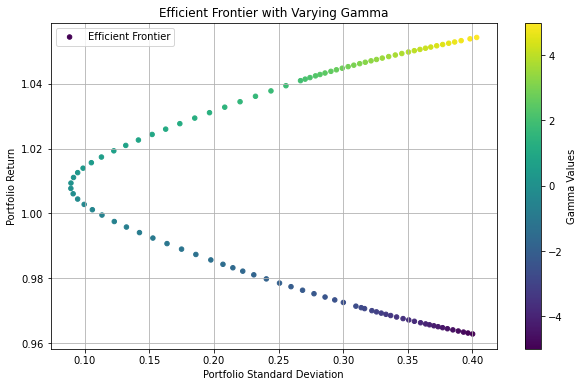

In [111]:
# Calculate the mean returns and covariance matrix
mean_returns = mu_hat
cov_matrix = omega_hat

# Define constraints
constraints = ({'type': 'eq', 'fun': constraint_fully_invested}) # fully invested portfolio
bounds = [(-1, 1)]* N_ASSETS # possession of asset in [-1, 1]

# Initialize weights
initial_weights = np.ones(N_ASSETS) / N_ASSETS

# Set gamma values
gamma_values = np.linspace(-5, 5, 100)  # Inverse of the risk aversion parameter

# Lists to store results
portfolio_returns = []
portfolio_std_devs = []
weights_gamma = []
objective_values = []

# Solve the problem for different values of gamma
for gamma_val in gamma_values:
    result = minimize(objective, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                      constraints=constraints, bounds=bounds)

    # Save results
    weights_gamma.append(list(result.x))
    portfolio_returns.append(np.dot(mean_returns, result.x))
    portfolio_std_devs.append(np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x))))
    objective_values.append(-result.fun)

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_std_devs, portfolio_returns, s=20, c=gamma_values, cmap='viridis', label='Efficient Frontier')
plt.colorbar(label='Gamma Values')
plt.title('Efficient Frontier with Varying Gamma')
plt.xlabel('Portfolio Standard Deviation')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid(True)
# plt.xlim())
plt.show()



# The Tangent Portfolio : shap ratio

In [112]:
# propostion of risk-free asset in the portfolio
ALPHA = 0.1
# risk-free rate
RISK_FREE_RATE = 0.95
# Set gamma values
GAMMA_VALUES = np.linspace(-5, 5, 100)  # Inverse of the risk aversion parameter

In [113]:
def plot_efficient_frontier(mean_returns, cov_matrix, constraints, bounds, gamma_values, risk_free_rate, alpha, abscisse_0=True):
    initial_weights = np.ones(len(mean_returns)) / len(mean_returns)
    
    weights_gamma = []
    mu_x, mu_y = [], []
    sigma_x, sigma_y = [], []

    for gamma_val in gamma_values:
        result = minimize(objective, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                          constraints=constraints, bounds=bounds)
        weights_gamma.append(list(result.x))

        mu = np.dot(mean_returns, result.x)
        mu_x.append(mu)
        mu_y.append((1 - alpha) * risk_free_rate + alpha * mu)

        sigma = np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x)))
        sigma_x.append(sigma)
        sigma_y.append(alpha * sigma)

    tangente_theta = [(a - risk_free_rate) / b for a, b in zip(mu_y, sigma_y)]
    tangente_index = np.argmax(tangente_theta)
    gamma_tangent = gamma_values[tangente_index]
    mu_x_tangent = mu_x[tangente_index]
    sigma_x_tangent = sigma_x[tangente_index]

    # Plot the efficient frontier
    plt.figure(figsize=(10, 6))
    plt.scatter(sigma_x, mu_x, s=20, c=gamma_values, cmap='viridis', label='Efficient Frontier')
    plt.colorbar(label='Gamma Values')
    plt.scatter(x=sigma_x_tangent, y=mu_x_tangent, marker='X', s=50, c='r', label='Optimal Gamma')
    
    # Plot the tangent portfolio
    abscisses = [min(sigma_x) * 0.98, max(sigma_x)]
    ordonnées = [risk_free_rate + (mu_x_tangent - risk_free_rate) / sigma_x_tangent * min(sigma_x) * 0.98,
                 risk_free_rate + (mu_x_tangent - risk_free_rate) / sigma_x_tangent * max(sigma_x)]

    if abscisse_0:
        # Include ordinate of x=0
        abscisses.insert(0, 0)
        ordonnées.insert(0, RISK_FREE_RATE)

    plt.plot(abscisses, ordonnées, alpha=0.7, c='grey')

    plt.title(f'Efficient Frontier with Varying Gamma reach optimum at {gamma_tangent}.')
    plt.xlabel('Portfolio Standard Deviation')
    plt.ylabel('Portfolio Return')
    plt.legend()
    plt.grid(True)
    plt.show()

In [114]:
# Calculate the mean returns and covariance matrix
mean_returns = mu_hat
cov_matrix = omega_hat

# Define constraints
constraints = ({'type': 'eq', 'fun': constraint_fully_invested}) # fully invested portfolio
bounds = [(-1, 1)] * N_ASSETS # possession of asset in [-1, 1]

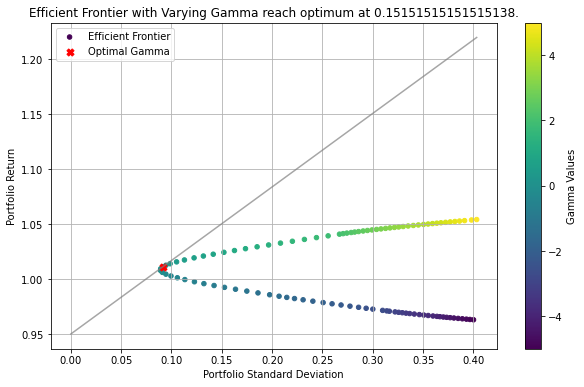

In [115]:
plot_efficient_frontier(mean_returns=mu_hat,
                        cov_matrix=omega_hat,
                        constraints={'type': 'eq', 'fun': constraint_fully_invested},
                        bounds=[(-1, 1)] * N_ASSETS,
                        gamma_values=GAMMA_VALUES,
                        risk_free_rate=RISK_FREE_RATE,
                        alpha=ALPHA,
                        abscisse_0=True)

# ESG Contrainte

## Focus on an unique max score

In [180]:
# Sustainalytics scores [APPL, BP, JPM] -> the smaller, the better
SUSTAINALYTICS_SCORES = [17.2, 34.6, 29.3, 24, 15, 29, 17, 13, 41, 25]
# Score max
MAX_SCORE = 25


In [117]:
def constraint_ESG_max(x_weights):
    return - (np.dot(SUSTAINALYTICS_SCORES, x_weights) - MAX_SCORE) # minus for having inferior or equal in the constraint

def plot_efficient_frontier(mean_returns, cov_matrix, constraints, bounds, gamma_values, risk_free_rate, alpha, color_bar='gamma', abscisse_0=True):
    initial_weights = np.ones(len(mean_returns)) / len(mean_returns)

    weights_gamma = []
    mu_x, mu_y = [], []
    sigma_x, sigma_y = [], []
    objective_values = []
    score_esg = []

    for gamma_val in gamma_values:
        result = minimize(objective, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                          constraints=constraints, bounds=bounds)
        weights_gamma.append(list(result.x))

        mu = np.dot(mean_returns, result.x)
        mu_x.append(mu)
        mu_y.append((1 - alpha) * risk_free_rate + alpha * mu)

        sigma = np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x)))
        sigma_x.append(sigma)
        sigma_y.append(alpha * sigma)

        objective_values.append(-result.fun)

        score_esg.append(np.dot(SUSTAINALYTICS_SCORES, list(result.x)))

    tangente_theta = [(a - risk_free_rate) / b for a, b in zip(mu_y, sigma_y)]
    tangente_index = np.argmax(tangente_theta)
    gamma_tangent = gamma_values[tangente_index]
    mu_x_tangent = mu_x[tangente_index]
    sigma_x_tangent = sigma_x[tangente_index]
    score_esg_tangent = score_esg[tangente_index]

    # Plot the efficient frontier
    plt.figure(figsize=(10, 6))

    if color_bar == 'gamma':
        plt.scatter(sigma_x, mu_x, s=20, c=gamma_values, cmap='viridis', label='Efficient Frontier')
        plt.colorbar(label='Gamma Values')
    elif color_bar == 'esg':
        plt.scatter(sigma_x, mu_x, s=20, c=score_esg, cmap='seismic', label='Efficient Frontier')
        plt.colorbar(label='ESG score')
 
    plt.scatter(x=sigma_x_tangent, y=mu_x_tangent, marker='X', s=50, c='r', label='Optimal Gamma')
    
    # Plot the tangent portfolio
    abscisses = [min(sigma_x) * 0.98, max(sigma_x)]
    ordonnées = [risk_free_rate + (mu_x_tangent - risk_free_rate) / sigma_x_tangent * min(sigma_x) * 0.98,
                 risk_free_rate + (mu_x_tangent - risk_free_rate) / sigma_x_tangent * max(sigma_x)]
    
    if abscisse_0:
        # Include ordinate of x=0
        abscisses.insert(0, 0)
        ordonnées.insert(0, RISK_FREE_RATE)

        
    plt.plot(abscisses, ordonnées, alpha=0.7, c='grey')

    plt.title(f'Efficient Frontier with Varying Gamma reach optimum at {gamma_tangent} and ESG score of {score_esg_tangent}.')
    plt.xlabel('Portfolio Standard Deviation')
    plt.ylabel('Portfolio Return')
    plt.legend()
    plt.grid(True)
    plt.show()

In [118]:
# Calculate the mean returns and covariance matrix
mean_returns = get_mu_hat(gross_returns_table=Y_full, end_date_for_the_empirical_sum=TIME_T)
cov_matrix = get_omega_hat(gross_returns_table=Y_full, end_date_for_the_empirical_sum=TIME_T)

# Define constraintsx
constraints = ({'type': 'eq', 'fun': constraint_fully_invested}, # fully invested portfolio
               {'type': 'ineq', 'fun': constraint_ESG_max}) # ESG score inferior to a constant
bounds = [(-1, 1)] * N_ASSETS # possession of asset in [-1, 1]

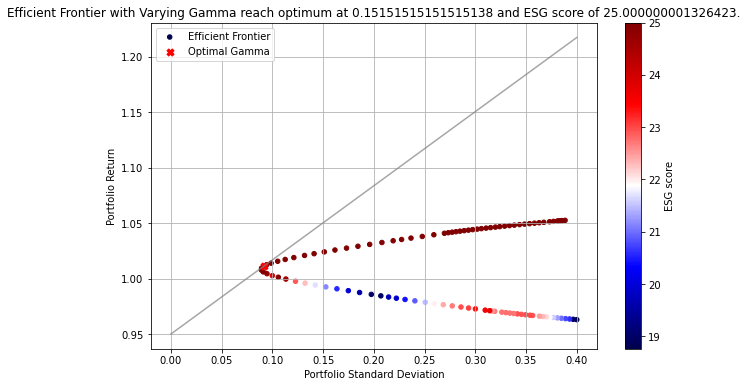

In [119]:
# Choose color bar type: 'gamma' or 'esg'
plot_efficient_frontier(mean_returns=mean_returns,
                        cov_matrix=cov_matrix,
                        constraints = constraints,
                        bounds=bounds,
                        gamma_values=GAMMA_VALUES,
                        risk_free_rate=RISK_FREE_RATE,
                        alpha=ALPHA,
                        color_bar='esg')

## Multiple ESG max score comparison

In [120]:
MAX_SCORES = np.linspace(np.min(SUSTAINALYTICS_SCORES), np.max(SUSTAINALYTICS_SCORES), 5)

In [121]:
def constraint_ESG_max(x_weights, max_score=MAX_SCORE):
    return - (np.dot(SUSTAINALYTICS_SCORES, x_weights) - max_score)

def get_efficient_frontier_data_multiple_max_esg_scores(mean_returns, cov_matrix, bounds, gamma_values, risk_free_rate, alpha, max_scores):
        
    data_dict = {}

    for max_score in max_scores:

        data_dict[max_score] = {}

        initial_weights = np.ones(len(mean_returns)) / len(mean_returns)

        weights_gamma = []
        mu_x, mu_y = [], []
        sigma_x, sigma_y = [], []
        objective_values = []
        score_esg = []

        for gamma_val in gamma_values:
            result = minimize(objective, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                            constraints=(
                                {'type': 'eq', 'fun': constraint_fully_invested},  # fully invested portfolio
                                {'type': 'ineq', 'fun': lambda x, max_score=max_score: constraint_ESG_max(x, max_score)}),
                            bounds=bounds)
            weights_gamma.append(list(result.x))

            mu = np.dot(mean_returns, result.x)
            mu_x.append(mu)
            mu_y.append((1 - alpha) * risk_free_rate + alpha * mu)

            sigma = np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x)))
            sigma_x.append(sigma)
            sigma_y.append(alpha * sigma)

            objective_values.append(-result.fun)

            score_esg.append(np.dot(SUSTAINALYTICS_SCORES, list(result.x)))

        tangente_theta = [(a - risk_free_rate) / b for a, b in zip(mu_y, sigma_y)]
        tangente_index = np.argmax(tangente_theta)
        gamma_tangent = gamma_values[tangente_index]
        mu_x_tangent = mu_x[tangente_index]
        sigma_x_tangent = sigma_x[tangente_index]
        score_esg_tangent = score_esg[tangente_index]

        data_dict[max_score]['mu_x'] = mu_x
        data_dict[max_score]['sigma_x'] = sigma_x
        data_dict[max_score]['mu_x_tangent'] = mu_x_tangent
        data_dict[max_score]['sigma_x_tangent'] = sigma_x_tangent
        data_dict[max_score]['gamma_tangent'] = gamma_tangent
        data_dict[max_score]['score_esg_tangent'] = score_esg_tangent
        data_dict[max_score]['tangente_theta'] = tangente_theta[tangente_index]
        
    return data_dict


def plot_efficient_frontier_data_multiple_max_esg_scores(mean_returns, cov_matrix, bounds, gamma_values, risk_free_rate, alpha, max_scores, abscisse_0 = True):

    data = get_efficient_frontier_data_multiple_max_esg_scores(mean_returns, cov_matrix, bounds, gamma_values, risk_free_rate, alpha, max_scores)

    # Générer une colormap en fonction de la taille de values_list
    cmap = plt.get_cmap('viridis')  # Vous pouvez choisir une autre colormap selon vos préférences
    colors = cmap(np.linspace(0, 1, len(list(data.keys()))))


    plt.figure(figsize=(10, 6))

    for idx, esg_score in enumerate(list(data.keys())):
        plt.plot(data[esg_score]['sigma_x'], data[esg_score]['mu_x'], c=colors[idx], label=f'Max ESG score of {np.round(esg_score, 1)}')

        # Plot the tangent portfolio
        abscisses = [min(data[esg_score]['sigma_x']) * 0.98, max(data[esg_score]['sigma_x'])]
        ordonnées = [RISK_FREE_RATE + (data[esg_score]['mu_x_tangent'] - RISK_FREE_RATE) / data[esg_score]['sigma_x_tangent'] * min(data[esg_score]['sigma_x']) * 0.98,
                    RISK_FREE_RATE + (data[esg_score]['mu_x_tangent'] - RISK_FREE_RATE) / data[esg_score]['sigma_x_tangent'] * max(data[esg_score]['sigma_x'])]

        if abscisse_0:
            # Include ordinate of x=0
            abscisses.insert(0, 0)
            ordonnées.insert(0, RISK_FREE_RATE)
            
        plt.plot(abscisses, ordonnées, alpha=0.7, c='grey')

    df_performance_esg_scores_debrief = pd.DataFrame([[key, data[key]["score_esg_tangent"], data[key]["gamma_tangent"], data[key]["tangente_theta"]] for key in list(data.keys())], columns=["max_score_esg","score_esg_tangent", "gamma_tangent", "tangente_theta"])

    plt.xlabel('Portfolio Standard Deviation')
    plt.ylabel('Portfolio Return')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.grid(True)
    plt.title(f'Efficient Frontier with varying max ESG score')
    plt.show()

    return data, df_performance_esg_scores_debrief

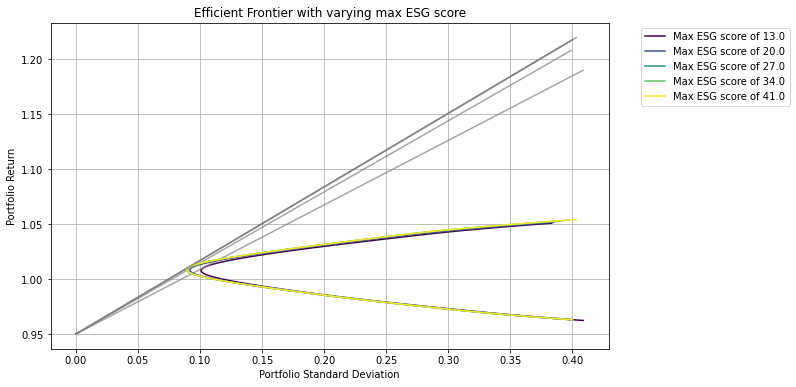

,max_score_esg,score_esg_tangent,gamma_tangent,tangente_theta
0,13.0,13.000000,0.151515,0.587291
1,20.0,20.000000,0.151515,0.646745
2,27.0,26.651216,0.151515,0.669354
3,34.0,26.651216,0.151515,0.669354
4,41.0,26.651216,0.151515,0.669354


In [122]:
data, df_performance_esg_scores_debrief = plot_efficient_frontier_data_multiple_max_esg_scores(mean_returns = mean_returns,
                                                cov_matrix = cov_matrix,
                                                bounds = bounds,
                                                gamma_values = gamma_values,
                                                risk_free_rate = RISK_FREE_RATE,
                                                alpha = ALPHA,
                                                max_scores = MAX_SCORES,
                                                abscisse_0 = True)

df_performance_esg_scores_debrief

**Interpretation:** 

- The lower your interest in ESG sensitivity (so the higher Sustainanlytics's max score), the higher the shift of the portfolio frontier in the upper-left direction. 
- It is also remarkable that the gradient of this shift is decreasing, ie. for $max_1 \leq max_2 \leq max_3$, the delta of the shift in portfolio frontier verifies $\Delta Shift_{max_1-to-max_2} >= \Delta Shift_{max_2-to-max_3}$.
- The delta shift is null at some point.

# Sharp Ratio en fonction MAX_SCORE

In [123]:
MAX_SCORES = np.linspace(np.min(SUSTAINALYTICS_SCORES), np.max(SUSTAINALYTICS_SCORES), 20)

In [124]:
def constraint_ESG_max(x_weights, max_score):
    return - (np.dot(SUSTAINALYTICS_SCORES, x_weights) - max_score)

def plot_sharpe_ratio_vs_max_score(mean_returns, cov_matrix, bounds, gamma_values, risk_free_rate, alpha, max_scores):
    initial_weights = np.ones(len(mean_returns)) / len(mean_returns)

    sharpe_ratios = []

    for max_score in max_scores:
        constraints = [
            {'type': 'eq', 'fun': constraint_fully_invested},  # fully invested portfolio
            {'type': 'ineq', 'fun': lambda x, max_score=max_score: constraint_ESG_max(x, max_score)}
        ]
        objective_values = []
        for gamma_val in gamma_values:
            result = minimize(objective, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                              constraints=constraints, bounds=bounds)
            objective_values.append(-result.fun)

        tangente_theta = [(a - risk_free_rate) / b for a, b in zip(objective_values, gamma_values)]
        tangente_index = np.argmax(tangente_theta)
        gamma_tangent = gamma_values[tangente_index]

        # Calcul du Sharpe ratio du portefeuille tangent
        weights_tangent = minimize(objective, initial_weights, args=(gamma_tangent, mean_returns, cov_matrix),
                                   constraints=constraints, bounds=bounds).x
        mu_tangent = np.dot(mean_returns, weights_tangent)
        sigma_tangent = np.sqrt(np.dot(weights_tangent.T, np.dot(cov_matrix, weights_tangent)))
        sharpe_ratio = (mu_tangent - risk_free_rate) / sigma_tangent

        sharpe_ratios.append(sharpe_ratio)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(max_scores, sharpe_ratios, marker='o', linestyle='-', color='b')
    plt.title('Sharpe Ratio of Tangent Portfolio vs Max ESG Score Constraint')
    plt.xlabel('Max ESG Score Constraint')
    plt.ylabel('Sharpe Ratio')
    plt.grid(True)
    plt.show()

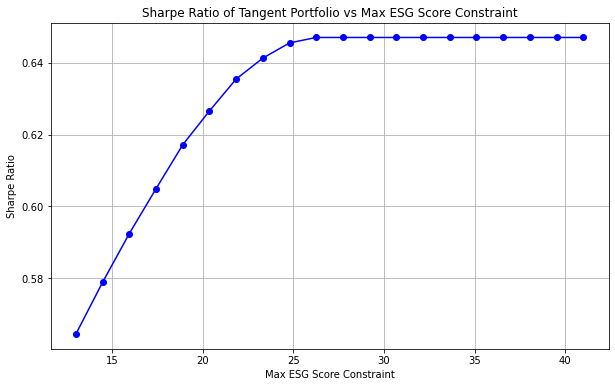

In [125]:
plot_sharpe_ratio_vs_max_score(mean_returns, cov_matrix, bounds, GAMMA_VALUES, RISK_FREE_RATE, ALPHA, MAX_SCORES)


# Perderson Model

In [303]:
SUSTAINALYTICS_SCORES_ = np.array(SUSTAINALYTICS_SCORES) * 0.001

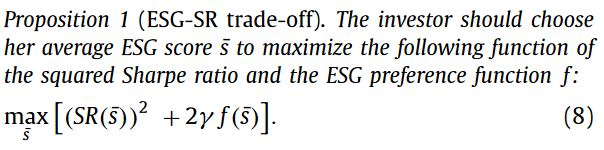

In [203]:
from IPython.display import Image
Image(filename='proposition1.jpg')

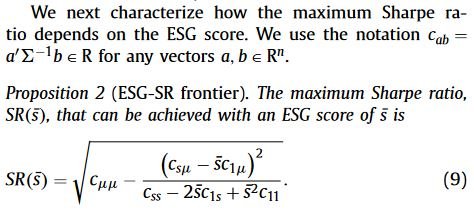

In [205]:
Image(filename='proposition2.jpg')

ESG efficient frontier with varying gamma in Perderson model

In [304]:
def Cab(a,b):
    return a @ np.linalg.inv(cov_matrix) @ b
def objective_perderson(weights, gamma, returns, cov_matrix):
    s_ = np.dot(SUSTAINALYTICS_SCORES_,weights)
    Cmumu = Cab(returns,returns)
    Csmu = Cab(SUSTAINALYTICS_SCORES_,returns)
    C1mu = Cab(np.ones(len(returns)),returns)
    Css = Cab(SUSTAINALYTICS_SCORES_,SUSTAINALYTICS_SCORES_)
    C1s = Cab(np.ones(len(returns)),SUSTAINALYTICS_SCORES_)
    C11 = Cab(np.ones(len(returns)),np.ones(len(returns)))
    sharpe_s = np.sqrt( Cmumu  - ((Csmu  - s_ *C1mu) **2) / ( Css - 2 * s_ * C1s + (s_** 2) * C11)  ) 
    obj = sharpe_s ** 2 + 2 * gamma * s_
    return -obj

def constraint_fully_invested(x_weights):
    return sum(x_weights) - 1


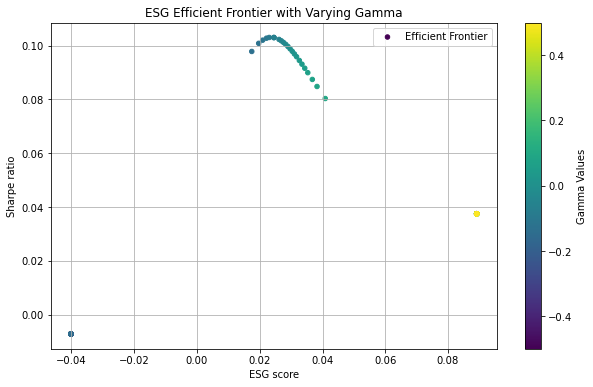

In [306]:
# Calculate the mean returns and covariance matrix
mean_returns = mu_hat - 1
cov_matrix = omega_hat

# Define constraints
constraints = ({'type': 'eq', 'fun': constraint_fully_invested}) # fully invested portfolio
bounds_ = [(-0.9, 0.9)]* N_ASSETS 

# Initialize weights
initial_weights = np.ones(N_ASSETS) / N_ASSETS

# Set gamma values
gamma_values = np.linspace(-0.5,0.5 , 100)  # Inverse of the risk aversion parameter

# Lists to store results
sharpe_ratios = []
esg_scores = []
weights_gamma = []
objective_values = []

# Solve the problem for different values of gamma
for gamma_val in gamma_values:
    result = minimize(objective_perderson, initial_weights, args=(gamma_val, mean_returns, cov_matrix),
                      constraints=constraints, bounds=bounds_)

    # Save results
    weights_gamma.append(list(result.x))
    sharpe_ratios.append(np.dot(mean_returns, result.x) / np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x))))
    esg_scores.append(np.dot(SUSTAINALYTICS_SCORES_,result.x))
    objective_values.append(-result.fun)

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(esg_scores, sharpe_ratios, s=20, c=gamma_values, cmap='viridis', label='Efficient Frontier')
plt.colorbar(label='Gamma Values')
plt.title('ESG Efficient Frontier with Varying Gamma')
plt.xlabel('ESG score')
plt.ylabel('Sharpe ratio')
plt.legend()
plt.grid(True)
# plt.xlim())
plt.show()

ESG efficient frontier with varying average ESG scores in Perderson model

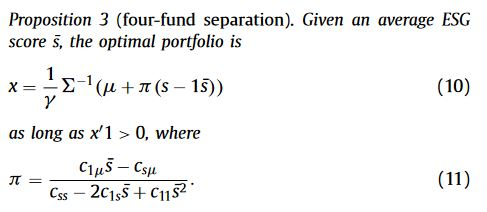

In [206]:
Image(filename='proposition3.jpg')

In [292]:
s_mean = np.linspace(min(SUSTAINALYTICS_SCORES),max(SUSTAINALYTICS_SCORES) , 100)

In [299]:
Csmu = Cab(SUSTAINALYTICS_SCORES,mean_returns)
C1mu = Cab(np.ones(len(mean_returns)),mean_returns)
Css = Cab(SUSTAINALYTICS_SCORES,SUSTAINALYTICS_SCORES)
C1s = Cab(np.ones(len(mean_returns)),SUSTAINALYTICS_SCORES)
C11 = Cab(np.ones(len(mean_returns)),np.ones(len(mean_returns)))

In [301]:
optimal_weights = []
gamma = 2
for s_ in s_mean:
    pi =  (C1mu * s_ - Csmu) / (Css - 2 * C1s * s_ + C11 * (s_**2) )
    optimal_weights.append((1/gamma) * np.linalg.inv(cov_matrix) @ (mean_returns + pi*(SUSTAINALYTICS_SCORES - s_)) )

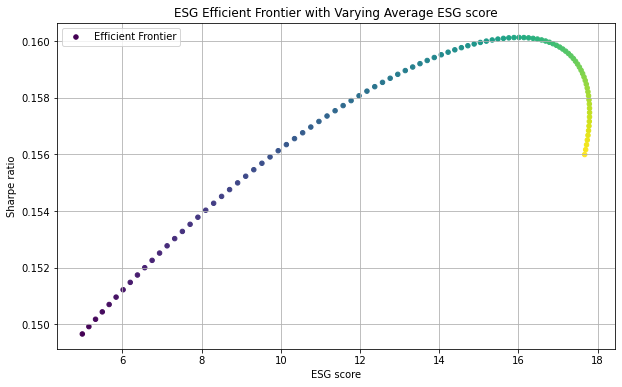

In [302]:
sharpe_ratios_ = []
esg_scores_ = []


# Solve the problem for different values of gamma
for weights in optimal_weights:

    sharpe_ratios_.append(np.dot(mean_returns, weights) / np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))))
    esg_scores_.append(np.dot(SUSTAINALYTICS_SCORES,weights))
plt.figure(figsize=(10, 6))
plt.scatter(esg_scores_, sharpe_ratios_, s=20, c=gamma_values, cmap='viridis', label='Efficient Frontier')
plt.title('ESG Efficient Frontier with Varying Average ESG score')
plt.xlabel('ESG score')
plt.ylabel('Sharpe ratio')
plt.legend()
plt.grid(True)
# plt.xlim())
plt.show()